# Preprocesamiento de datos

Con el fin de poder entrenar los diversos modelos de Machine Learning y
Deep learning, es necesário hacer un preprocesamiento de los datos para 
poder obtener un único DataFrame con todas las características necesárias

## Carga de datos

Antes de poder manipular los diferentes datos, primero es necesário
cargarlos en el sistema

In [1]:
import pandas as pd
import polars as pl
import numpy as np 
from pathlib import Path

In [2]:
# Directório de archivos
data_folder = Path("../data/predict-energy-behavior-of-prosumers")

# Diccionario de archivos
files = {
    "train": "train.csv",
    "gas_prices": "gas_prices.csv",
    "client": "client.csv",
    "electricity_prices": "electricity_prices.csv",
    "forecast_weather": "forecast_weather.csv",
    "historical_weather": "historical_weather.csv",
    "county_lon_lats": "county_lon_lats.csv",
    "weather_station": "weather_station_to_county_mapping.csv"
}

In [3]:
# Se crea un diccionario de DataFrames para acceder facilmente a todos
# y poder iterar sobre ellos si es necesário
dfs = {}

for key, filename in files.items():
    filepath = data_folder / filename
    try:
        df = pl.read_csv(filepath)
        dfs[key] = df
        print(f"Archivo {key} cargado con exito.")
    except:
        print(f"No pudo cargarse el archivo {key}.")
    

Archivo train cargado con exito.
Archivo gas_prices cargado con exito.
Archivo client cargado con exito.
Archivo electricity_prices cargado con exito.
Archivo forecast_weather cargado con exito.
Archivo historical_weather cargado con exito.
Archivo county_lon_lats cargado con exito.
Archivo weather_station cargado con exito.


## Asignación de longitud/latitud a un condado especifico

Con el fin de poder unir los csv de "train.csv" y "forecast_weather.csv"
es necesario poder asignar a cada longitud y latitud, su condado
correspondiente.

Para ello se utilizará el archivo "county_lon_lats" obtenido de la página
de [kaggle](https://www.kaggle.com/datasets/michaelo/fabiendaniels-mapping-locations-and-county-codes/data)
con datos que asignan latitudes y longitudes a su correspondiente condado.

### Visualización de los datos

In [4]:
import matplotlib.pyplot as plt

KeyboardInterrupt: 

In [ ]:
dfs["weather_station"]

county_name,longitude,latitude,county
str,f64,f64,i64
null,21.7,57.6,null
null,21.7,57.9,null
null,21.7,58.2,null
null,21.7,58.5,null
null,21.7,58.8,null
…,…,…,…
null,28.2,58.5,null
null,28.2,58.8,null
null,28.2,59.1,null


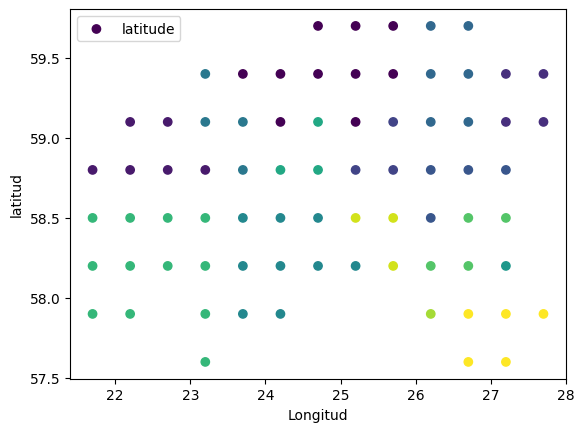

In [ ]:
plt.scatter('longitude', 'latitude', c='county', data=dfs["county_lon_lats"])
plt.xlabel("Longitud")
plt.ylabel("latitud")
plt.legend()
plt.show()

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from warnings import filterwarnings
filterwarnings("ignore")

In [ ]:
# obtención de X e y
X = dfs["county_lon_lats"].drop("county")
y = dfs["county_lon_lats"]["county"].to_numpy()

## Predicción y comparación de modelos

A continuación se presentan 3 modelos (KNN, Kmeans\[moda\] y
RBF-SVM) los cuales se compararán para averiguar cual de los 3 
da una mayor precisión.

In [ ]:
def plot_lines(
        X: np.array, *y: np.array, xlabel:str=None, 
        ylabel:str=None, legend:bool=False,
        legend_labels:np.array=None
    ):
    """
    Imprime uno o mas diagramas de linea sobre
    el mismo eje X

    Parameters
    ----------
    X: np.array
        Eje X del diagrama
    *y: np.array
        Tupla con los ejes y del diagrama
    xlabel: str, optional
        Etiqueta del eje X del diagrama
    ylabel: str, optional
        Etiqueta del eje y del diagrama
    legend: bool, optional
        Si es 'True' imprime la legenda del diagrama
    legend_labels: array, optional
        Strings de la legenda

    """
    for line, lab in zip(y, legend_labels):
        plt.plot(X, line, label=lab)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if legend:
        plt.legend()
    plt.show()

#### Clases

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics.pairwise import euclidean_distances
from statistics import mode

In [ ]:
# Calcula y agrupa los datos en clusters utilizando el criterio de la moda
class kmedias_moda:
    def __init__(self, n_clusters) -> None:
        self.k = n_clusters
        self.moda = -1 * np.ones(self.k, dtype=int)

    def fit(self, X, y):
        self.model = KMeans(self.k)
        self.model.fit(X)

        for i in range(self.k):
            self.moda[i] = mode(y[self.model.labels_ == i])
    
    def predict(self, X):
        return self.moda[self.model.predict(X)]
    
    def score(self, X, y):
        return np.mean(self.predict(X) == y)

In [ ]:
class oculta_rbf:
    '''
    Calcula los centroides de un modelo Kmeans al cual se le 
    aplica una función RBF utilizando la distancia entre los centroides
    '''

    def __init__(self, n_clusters) -> None:
        self.k = n_clusters
    
    def fit(self, X):
        self.kmeans = KMeans(self.k)
        self.kmeans.fit(X)

        self.centers = self.kmeans.cluster_centers_
        dist = euclidean_distances(X, self.centers)
        self.sigma = np.sum(dist, axis=0)/(dist.shape[0] - 1)
    
    def predict(self, X):
        return np.exp(
            (-euclidean_distances(X, self.centers)**2)/(
                2.0*(self.sigma**2)
            )
        )

In [ ]:
class RBF_SVM:
    def __init__(self, n_clusters:int, degree:int, scale=False):
        self.oculta = oculta_rbf(n_clusters)
        self.svm = SVC(kernel='poly', degree=degree)
        self.scale=scale
        self.scaler = MinMaxScaler()
    
    def fit(self, X, y):
        if self.scale:
            X = self.scaler.fit_transform(X)
        self.oculta.fit(X)
        self.svm.fit(self.oculta.predict(X), y)

    def predict(self, X):
        if self.scale:
            X = self.scaler.transform(X)
        return self.svm.predict(self.oculta.predict(X))
    
    def score(self, X, y):
        if self.scale:
            X = self.scaler.transform(X)
        return self.svm.score(self.oculta.predict(X), y)

In [ ]:
def cast_dataframe(df: pl.DataFrame) -> pl.DataFrame:
    """
    Realiza un downcast de todas las columnas con valores
    numéricos de un dataframe dado.

    Parameters
    ----------
    df : pl.DataFrame
        El DataFrame a modificar
    
    Returns
    -------
    pl.DataFrame
        El DataFrame modificado
    """

    for col in df.columns:
        column = df[col]
        col_dtype = column.dtype

        # Downcast de enteros
        if col_dtype == pl.Int64 or col_dtype == pl.Int32 or col_dtype == pl.Int16:

            min_val, max_val = column.min(), column.max()

            if np.iinfo(np.int8).min <= min_val <= max_val <= np.iinfo(np.int8).max:
                new_type = pl.Int8
            elif np.iinfo(np.int16).min <= min_val <= max_val <= np.iinfo(np.int16).max:
                new_type = pl.Int16
            elif np.iinfo(np.int32).min <= min_val <= max_val <= np.iinfo(np.int32).max:
                new_type = pl.Int32
            else:
                new_type = pl.Int64

            df = df.with_columns(pl.col(col).cast(new_type))
        
        # Downcast de punto flotante
        elif col_dtype == pl.Float64:

            min_val, max_val = column.min(), column.max()

            if np.finfo(np.float32).min <= min_val <= max_val <= np.finfo(np.float32).max:
                new_type = pl.Float32
            else:
                new_type = pl.Float64
            
            df = df.with_columns(pl.col(col).cast(new_type))
        
    return df


In [ ]:
def get_scores(X, y, range_items, model, clusters:int=None, n_folds:int=10):
    """
    Realiza una prueba de estratificación cruzada sobre
    un modelo y calcula la precisión de cada Fold

    Parameters
    ----------
    X:
        Datos totales del conjunto
    y:
        Clase del Conjunto
    model:
        Clase del modelo a entrenar
    clusters: int, optional
        Númeor de clusters del modelo RBF_SVM
    n_folds: int, optional
        Número de particiones del K-Fold
    
    Returns
    -------
    (np.array, np.array):
        Tupla con las puntuaciones del conjuntop Train y Test
    """

    skf = StratifiedKFold(n_folds)
    X_scl = MinMaxScaler().fit_transform(X)

    train_scores = np.array([])
    test_scores = np.array([])

    # Se itera sobre el parámetro a optimizar
    for i in range_items:
        fold_train_scores = np.array([])
        fold_test_scores = np.array([])

        # K-Fold Estratificado
        for train_idx, test_idx in skf.split(X, y):
            X_train, X_test = X_scl[train_idx], X_scl[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            # Instanciación del modelo a entrenar
            if model in [KNeighborsClassifier, kmedias_moda]:
                m = model(i)
            elif model == RBF_SVM and clusters != None:
                m = model(clusters, i)

            # Entrenamiento del modelo
            m.fit(X_train, y_train)

            # Se guardan los resultados de cada iteración
            fold_train_scores = np.append(
                fold_train_scores,
                m.score(X_train, y_train)
            )

            fold_test_scores = np.append(
                fold_test_scores,
                m.score(X_test, y_test)
            )
        
        # Se calculan los resultados de cada Fold
        train_scores = np.append(train_scores, fold_train_scores.mean())
        test_scores = np.append(test_scores, fold_test_scores.mean())

    return train_scores, test_scores

### Downcast
Se realiza un cast a a todos los datatypes de las columnas
de los DataFrames para reducier el coste computacional del 
entrenamiento y los merge

In [ ]:
for key in dfs.keys():
    dfs[key] = cast_dataframe(dfs[key])

### KNN
Se comprueba la precisión del modelo Vecinos mas próximos

In [ ]:
n_neighbors = np.arange(start=1, step=2, stop=21)
train_scores, test_scores = get_scores(X, y, n_neighbors, KNeighborsClassifier)

In [ ]:
train_scores, test_scores

(array([1.        , 0.90959175, 0.87546093, 0.85930641, 0.78950834,
        0.74205443, 0.6797849 , 0.66038191, 0.59374451, 0.54484197]),
 array([0.60357143, 0.68571429, 0.74285714, 0.7375    , 0.67321429,
        0.64821429, 0.56607143, 0.51428571, 0.51428571, 0.47678571]))

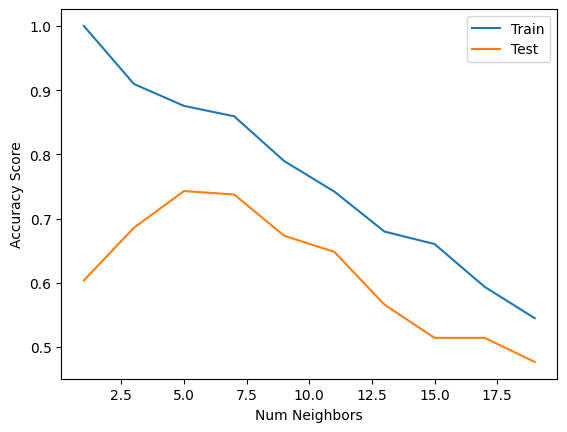

In [ ]:
plot_lines(
    n_neighbors, 
    train_scores, 
    test_scores,
    xlabel="Num Neighbors",
    ylabel="Accuracy Score",
    legend=True,
    legend_labels=["Train", "Test"]
)

In [ ]:
nn_optim = n_neighbors[test_scores == test_scores.max()].item()
knn_score = test_scores.max()
print(f"neighbors_optim: {nn_optim}")
print(f"score: {knn_score}")

neighbors_optim: 5
score: 0.7428571428571428


### KMeans y SVC con capa oculta RBF

#### Obtención de num. clusters óptimo
Se calcula el número óptimo de clusters que debe tener KMeans
para poder maximizar el resultado de la capa oculta con RBF.  

A su vez, estos resultados nos permite saber por separado 
la precisión del modelo KMeans para la predición de los condados.

In [ ]:
n_clusters = np.arange(start=1, stop=16)
train_scores, test_scores = get_scores(X, y, n_clusters, kmedias_moda)

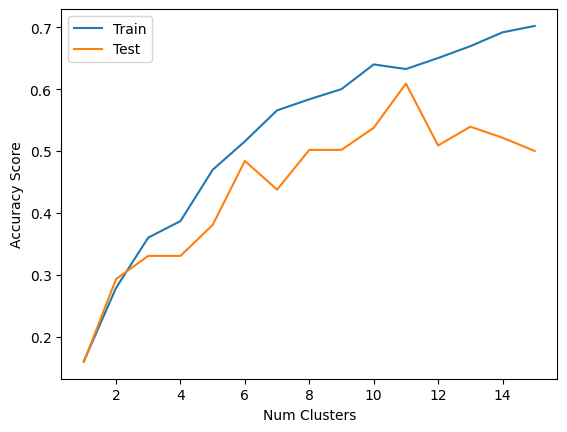

In [ ]:
plot_lines(
    n_clusters, 
    train_scores, 
    test_scores,
    xlabel="Num Clusters",
    ylabel="Accuracy Score",
    legend=True,
    legend_labels=["Train", "Test"]
)

In [ ]:
k_optim = n_clusters[test_scores == test_scores.max()].item()
km_score = test_scores.max()
print(f"k_optim: {k_optim}\nscore: {km_score}")

k_optim: 11
score: 0.6089285714285715


#### Cálculo del grado óptimo
Se calcula el grádo óptimo del kernel polinómico de la SVM 
para maximizar el resultado.

In [ ]:
grados = np.arange(start=2, stop=10)
train_scores, test_scores = get_scores(X, y, grados, RBF_SVM, clusters=k_optim)

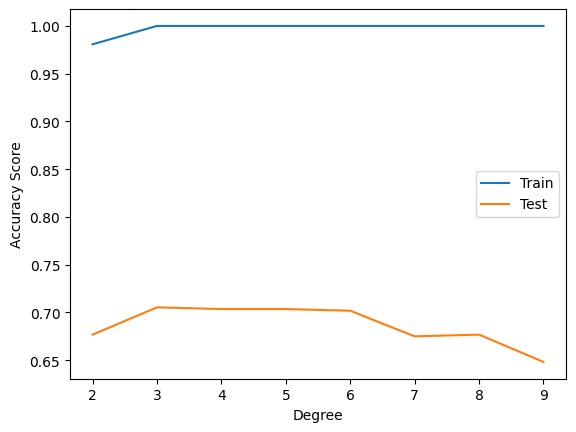

In [ ]:
plot_lines(
    grados, 
    train_scores, 
    test_scores,
    xlabel="Degree",
    ylabel="Accuracy Score",
    legend=True,
    legend_labels=["Train", "Test"]
)

In [ ]:
grad_optim = grados[test_scores == test_scores.max()].item()
svm_score = test_scores.max()
print(f"grad_optim: {grad_optim}\nscore: {svm_score}")

grad_optim: 3
score: 0.7053571428571428


Obtenidos los resultados óptimos comparamos los 3 modelos:

In [ ]:
print(f"KNN:\n\tnn_optim: {nn_optim}\n\tscore: {knn_score}")
print(f"KMeans:\n\tk_optim: {k_optim}\n\tscore: {km_score}")
print(f"RBF_SVM:\n\tdeg_optim: {grad_optim}\n\tscore: {svm_score}")

KNN:
	nn_optim: 5
	score: 0.7428571428571428
KMeans:
	k_optim: 11
	score: 0.6089285714285715
RBF_SVM:
	deg_optim: 3
	score: 0.7053571428571428


Puede observarse que el modelo que mejor resultado da a la hora de predecir el conjunto de entrenamiento
es KNN con un número óptimo de vecinos entre 3 y 5 (Dependiendo de la ejecución)

## Unión de DataFrames

Conociendo el mejor modelo para predecir el condado
se puede proceder con la unión de los DataFrames

In [ ]:
def add_county(df: pl.DataFrame, model, scaler):
    """
    Añade la predicción de los condados 
    al dataframe dado.

    Parameters
    ----------
    df: pl.DataFrame
        DataFrame a añadir los condados
    model:
        Modelo entrenado de machine learning
    scaler:
        Preprocesador de los datos
    
    Returns
    -------
    DataFrame con la columna de condados añadida
    """
    cols = ["longitude", "latitude"]
    print(df.columns)
    coords = df.select(pl.col(cols))
    coords_scl = scaler.transform(coords)
    countys = model.predict(coords_scl)

    return df.with_columns(pl.Series("county", countys, dtype=pl.Int8)).drop(cols)

In [ ]:
# Se escalan los datos
scaler = MinMaxScaler()
X_scl = scaler.fit_transform(X)

# Se entrena el modelo
model = KNeighborsClassifier(n_neighbors=nn_optim)
model.fit(X_scl, y)

# Se añaden los resultados a los dataframes
dfs["historical_weather"] = add_county(
    dfs["historical_weather"],
    model,
    scaler
)

dfs["forecast_weather"] = add_county(
    dfs["forecast_weather"],
    model,
    scaler
)

['datetime', 'temperature', 'dewpoint', 'rain', 'snowfall', 'surface_pressure', 'cloudcover_total', 'cloudcover_low', 'cloudcover_mid', 'cloudcover_high', 'windspeed_10m', 'winddirection_10m', 'shortwave_radiation', 'direct_solar_radiation', 'diffuse_radiation', 'latitude', 'longitude', 'data_block_id']
['latitude', 'longitude', 'origin_datetime', 'hours_ahead', 'temperature', 'dewpoint', 'cloudcover_high', 'cloudcover_low', 'cloudcover_mid', 'cloudcover_total', '10_metre_u_wind_component', '10_metre_v_wind_component', 'data_block_id', 'forecast_datetime', 'direct_solar_radiation', 'surface_solar_radiation_downwards', 'snowfall', 'total_precipitation']


In [ ]:
dfs["forecast_weather"].columns

['origin_datetime',
 'hours_ahead',
 'temperature',
 'dewpoint',
 'cloudcover_high',
 'cloudcover_low',
 'cloudcover_mid',
 'cloudcover_total',
 '10_metre_u_wind_component',
 '10_metre_v_wind_component',
 'data_block_id',
 'forecast_datetime',
 'direct_solar_radiation',
 'surface_solar_radiation_downwards',
 'snowfall',
 'total_precipitation',
 'county']

In [ ]:
# train - electricity_prices
ep_df = dfs["electricity_prices"].rename({"forecast_date": "datetime"}).drop(["origin_date"])
final_data = dfs["train"].drop(["row_id"]).join(
    ep_df,
    how="left",
    on=["data_block_id", "datetime"]
)

# Final - historical_weather
hw_df = dfs["historical_weather"]
final_data = final_data.join(
    hw_df,
    how="left",
    on=["datetime", "county"]
)

In [ ]:
final_data

county,is_business,product_type,target,is_consumption,datetime,data_block_id,prediction_unit_id,euros_per_mwh,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,data_block_id_right
i8,i8,i8,f32,i8,str,i16,i8,f32,f32,f32,f32,f32,f32,i8,i8,i8,i8,f32,i16,f32,f32,f32,f32
0,0,1,0.713,0,"""2021-09-01 00:00:00""",0,0,null,13.5,10.5,0.0,0.0,1009.5,46,49,0,7,4.416667,347,0.0,0.0,0.0,1.0
0,0,1,0.713,0,"""2021-09-01 00:00:00""",0,0,null,13.2,10.8,0.0,0.0,1005.900024,78,87,0,0,3.388889,336,0.0,0.0,0.0,1.0
0,0,1,0.713,0,"""2021-09-01 00:00:00""",0,0,null,12.6,10.5,0.0,0.0,1004.799988,90,98,3,0,2.861111,324,0.0,0.0,0.0,1.0
0,0,1,0.713,0,"""2021-09-01 00:00:00""",0,0,null,11.6,9.7,0.0,0.0,1002.700012,94,99,9,0,2.305556,304,0.0,0.0,0.0,1.0
0,0,1,0.713,0,"""2021-09-01 00:00:00""",0,0,null,14.0,10.7,0.0,0.0,1014.400024,20,17,1,14,6.75,352,0.0,0.0,0.0,1.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
15,1,0,197.233002,1,"""2023-05-31 23:00:00""",637,64,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
15,1,1,0.0,0,"""2023-05-31 23:00:00""",637,59,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
15,1,1,28.403999,1,"""2023-05-31 23:00:00""",637,59,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null


In [ ]:
dfs["client"].head()

product_type,county,eic_count,installed_capacity,is_business,date,data_block_id
i8,i8,i16,f32,i8,str,i16
1,0,108,952.890015,0,"""2021-09-01""",2
2,0,17,166.399994,0,"""2021-09-01""",2
3,0,688,7207.879883,0,"""2021-09-01""",2
0,0,5,400.0,1,"""2021-09-01""",2
1,0,43,1411.0,1,"""2021-09-01""",2


In [ ]:
# capacidad media de cada cliente por fecha

In [ ]:
dfs["client"].group_by(["date", "county", "product_type", "is_business"],
                       maintain_order = True).agg(pl.col("installed_capacity").mean())

date,county,product_type,is_business,installed_capacity
str,i8,i8,i8,f32
"""2021-09-01""",0,1,0,952.890015
"""2021-09-01""",0,2,0,166.399994
"""2021-09-01""",0,3,0,7207.879883
"""2021-09-01""",0,0,1,400.0
"""2021-09-01""",0,1,1,1411.0
…,…,…,…,…
"""2023-05-29""",15,1,0,415.600006
"""2023-05-29""",15,3,0,2035.75
"""2023-05-29""",15,0,1,620.0


In [ ]:
class DataProcessor:
    def __init__(self):
        self.gas_join = ["data_block_id"]
        self.ep_join = ["datetime", "data_block_id"]
        self.hw_join = ["datetime", "county", "data_block_id"]
        self.client_join = ["county", "is_business", "product_type", "data_block_id"]

        self.lat_lon = ["latitude", "longitude"]

    def change_names(self, df, suffix, no_change):
        renamed_df = df.rename(
            lambda col: col + suffix if col not in no_change else col
        )
        return renamed_df

    def get_gas_features(self, gas_df):
        gas_df = gas_df.with_columns(
            ((pl.col("lowest_price_per_mwh") + 
              pl.col("highest_price_per_mwh")) / 2).alias("mean_price_per_mwh")
        )

        return self.change_names(gas_df, "_gas", self.gas_join)
    
    def get_client_features(self, client_df):
        return self.change_names(client_df, "_client", self.client_join)
    
    def get_hist_weather_features(self, hw_df):
        return self.change_names(hw_df, "_hw", self.hw_join)
    
    def get_forecast_weather_features(self, fw_df):
        return None
    
    

In [42]:
dfs["gas_prices"]

forecast_date,lowest_price_per_mwh,highest_price_per_mwh,origin_date,data_block_id
str,f32,f32,str,i16
"""2021-09-01""",45.23,46.32,"""2021-08-31""",1
"""2021-09-02""",45.619999,46.290001,"""2021-09-01""",2
"""2021-09-03""",45.849998,46.400002,"""2021-09-02""",3
"""2021-09-04""",46.299999,46.799999,"""2021-09-03""",4
"""2021-09-05""",46.299999,46.580002,"""2021-09-04""",5
…,…,…,…,…
"""2023-05-26""",29.1,34.099998,"""2023-05-25""",633
"""2023-05-27""",28.299999,34.099998,"""2023-05-26""",634
"""2023-05-28""",28.1,34.099998,"""2023-05-27""",635


In [44]:
dfs["gas_prices"].head(3)

forecast_date,lowest_price_per_mwh,highest_price_per_mwh,origin_date,data_block_id
str,f32,f32,str,i16
"""2021-09-01""",45.23,46.32,"""2021-08-31""",1
"""2021-09-02""",45.619999,46.290001,"""2021-09-01""",2
"""2021-09-03""",45.849998,46.400002,"""2021-09-02""",3


In [45]:
dfs["gas_prices"].with_columns(
    ((pl.col("lowest_price_per_mwh") + 
    pl.col("highest_price_per_mwh")) / 2).alias("mean_price_per_mwh")
)

forecast_date,lowest_price_per_mwh,highest_price_per_mwh,origin_date,data_block_id,mean_price_per_mwh
str,f32,f32,str,i16,f32
"""2021-09-01""",45.23,46.32,"""2021-08-31""",1,45.775002
"""2021-09-02""",45.619999,46.290001,"""2021-09-01""",2,45.955002
"""2021-09-03""",45.849998,46.400002,"""2021-09-02""",3,46.125
"""2021-09-04""",46.299999,46.799999,"""2021-09-03""",4,46.549999
"""2021-09-05""",46.299999,46.580002,"""2021-09-04""",5,46.440002
…,…,…,…,…,…
"""2023-05-26""",29.1,34.099998,"""2023-05-25""",633,31.599998
"""2023-05-27""",28.299999,34.099998,"""2023-05-26""",634,31.199999
"""2023-05-28""",28.1,34.099998,"""2023-05-27""",635,31.099998
